<a href="https://colab.research.google.com/github/skashyapsri/Absorbance-Prediction-Using-ML/blob/main/EVOO_Pigment_Analysis_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVOO Pigment Analysis using Deep Learning


## Import Libraries

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim

## Load Pigments Data

In [75]:
pigments_data = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/pigments/pigments.csv', delimiter=';', comment='#')
MW = pigments_data.iloc[0, 1:].astype(float).values  # g/mol
pigments_data = pigments_data.iloc[2:].reset_index(drop=True)
pigments_data = pigments_data.rename(columns={'Wavelength (nm)': 'Wavelength'})
pigments_data['Wavelength'] = pd.to_numeric(pigments_data['Wavelength'], errors='coerce')
pigments_data = pigments_data.dropna()

## Define Helper Functions


In [76]:
def apply_baseline_correction(absorbance):
    return absorbance - np.min(absorbance)

def select_wavelength_range(data, start, end):
    return data[(data['Wavelength'] >= start) & (data['Wavelength'] <= end)]

## Define PyTorch Model

## Model Architecture

Key aspects of `DeconvolutionModel`:

1. **Type**: Fully connected neural network
2. **Layers**: Single layer with learnable parameters
3. **Input**: Normalized extinction coefficients (epsilon) of pigments
4. **Output**: Calculated absorbance spectrum


## Key Features

1. **Learnable Parameters**: The model learns the concentrations of each pigment, represented by `self.concentrations`.
2. **Non-Negativity Constraint**: ReLU activation ensures that the learned concentrations are always non-negative, which is physically meaningful for concentration values.
3. **Linear Combination**: The forward pass computes a linear combination of the input extinction coefficients, weighted by the learned concentrations.
4. **Optical Path Length**: The result is multiplied by `b`, representing the optical path length.


In [77]:
class DeconvolutionModel(nn.Module):
    def __init__(self, num_pigments):
        super(DeconvolutionModel, self).__init__()
        self.concentrations = nn.Parameter(torch.rand(num_pigments))

    def forward(self, epsilon):
        positive_concentrations = nn.functional.relu(self.concentrations)
        return torch.matmul(positive_concentrations, epsilon) * b

## Define Training Function

## Training Process

1. **Loss Function**: Mean Squared Error (MSE) between calculated and experimental absorbance spectra.
2. **Optimizer**: Adam optimizer with a learning rate of 0.001.
3. **Training Duration**: 5000 epochs by default, with the option to adjust.
4. **Batch Processing**: The entire dataset is used in each forward pass (no mini-batches).

In [78]:
def train_model(A_exp, epsilon, num_epochs=5000, learning_rate=0.001):
    model = DeconvolutionModel(epsilon.shape[0])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    A_exp_tensor = torch.FloatTensor(A_exp)
    epsilon_tensor = torch.FloatTensor(epsilon)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        A_calc = model(epsilon_tensor)
        loss = criterion(A_calc, A_exp_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

## Define Analysis Function

In [79]:
def analyze_dataset(file_url, pigments_data):

    print(f"\nAnalyzing dataset: {file_url.split('/')[-1]}")

    evoo_samples = pd.read_csv(file_url, delimiter=';')
    evoo_samples.columns = ['Wavelength', 'Absorbance']
    evoo_samples['Wavelength'] = pd.to_numeric(evoo_samples['Wavelength'], errors='coerce')
    evoo_samples = evoo_samples.dropna()

    wavelength_start, wavelength_end = 390, 720
    evoo_samples = select_wavelength_range(evoo_samples, wavelength_start, wavelength_end)
    pigments_data_filtered = select_wavelength_range(pigments_data, wavelength_start, wavelength_end)

    wavelengths = evoo_samples['Wavelength'].values
    A_exp = evoo_samples['Absorbance'].values.astype(float)
    A_exp = apply_baseline_correction(A_exp)

    epsilon = pigments_data_filtered.iloc[:, 1:].astype(float).values.T
    epsilon = np.maximum(epsilon, 0)
    epsilon_max = np.max(epsilon, axis=1, keepdims=True)
    epsilon_max[epsilon_max == 0] = 1
    epsilon_normalized = epsilon / epsilon_max

    model = train_model(A_exp, epsilon_normalized)
    final_concentrations = nn.functional.relu(model.concentrations).detach().numpy()
    A_calc = np.dot(final_concentrations, epsilon_normalized) * b
    r2 = r2_score(A_exp, A_calc)

    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, A_exp, 'k-', label='Experimental', linewidth=2)
    plt.plot(wavelengths, A_calc, 'g-', label='Calculated', linewidth=2)
    for i, name in enumerate(pigments_data.columns[1:]):
        plt.plot(wavelengths, final_concentrations[i] * epsilon_normalized[i] * b, label=name)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.legend()
    plt.title(f'Experimental vs Calculated Absorbance - {file_url.split("/")[-1]}')
    plt.show()

    print(f"R-square = {r2:.6f}")
    print("    PIGMENT CONCENTRATION")
    print("-------------------------------")
    total_concentration = 0
    for name, conc in zip(pigments_data.columns[1:], final_concentrations):
        conc_mg_kg = (conc * MW[pigments_data.columns[1:].get_loc(name)] * 1000 / evoo_density)
        print(f"{name:<12} = {conc_mg_kg:9.3f} mg/kg")
        total_concentration += conc_mg_kg
    print("-------------------------------")
    print(f"PIGMENT TOTAL = {total_concentration:9.3f} mg/kg")

## Set Constants and Define Datasets

In [80]:
b = 1.0  # optical path in cm
evoo_density = 0.9  # EVOO density in g/ml
datasets = [
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/evoo_test.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/fresh_evoo.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/mais_seed_oil.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/monocultivar_frantoio.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/rapeseed_oil.csv'
]


## Model Interpretation

- The learned `concentrations` directly correspond to the relative amounts of each pigment in the EVOO sample.
- The model essentially performs a spectral deconvolution, separating the contributions of individual pigments to the overall absorbance spectrum.

## Advantages of This Approach

1. **Physical Interpretability**: The model's structure mirrors the Beer-Lambert law, making the results physically meaningful.
2. **Flexibility**: Can be easily adapted to different numbers of pigments or spectral ranges.
3. **Non-Negativity**: Ensures physically realistic (non-negative) concentration values.
4. **End-to-End Learning**: Directly learns concentrations from spectral data without intermediate steps.

## Analysis of EVOO


Analyzing dataset: evoo_test.csv
Epoch [500/5000], Loss: 0.0129
Epoch [1000/5000], Loss: 0.0050
Epoch [1500/5000], Loss: 0.0034
Epoch [2000/5000], Loss: 0.0027
Epoch [2500/5000], Loss: 0.0022
Epoch [3000/5000], Loss: 0.0020
Epoch [3500/5000], Loss: 0.0019
Epoch [4000/5000], Loss: 0.0019
Epoch [4500/5000], Loss: 0.0019
Epoch [5000/5000], Loss: 0.0019


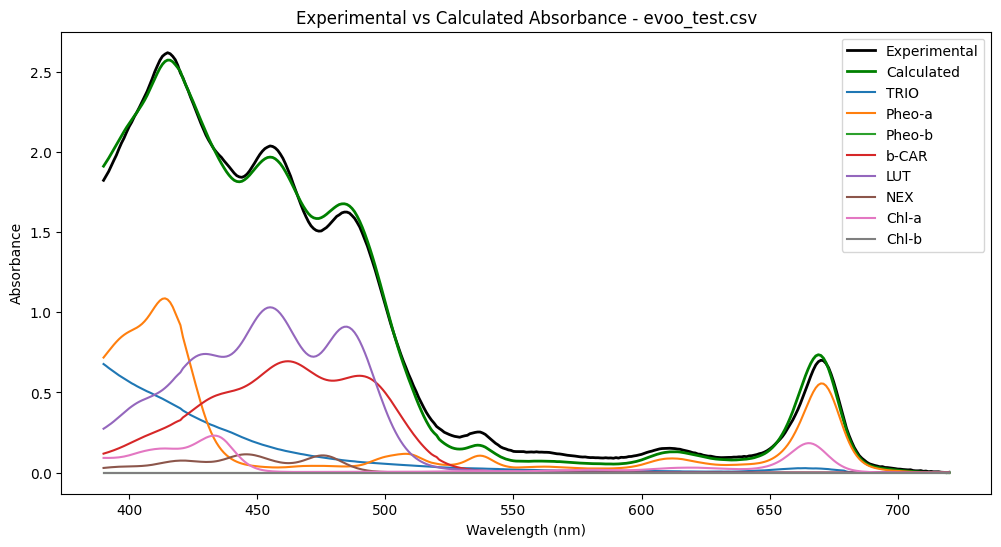

R-square = 0.997474
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = 666381.118 mg/kg
Pheo-a       = 1051775.897 mg/kg
Pheo-b       =     0.000 mg/kg
b-CAR        = 414409.936 mg/kg
LUT          = 651587.961 mg/kg
NEX          = 76575.354 mg/kg
Chl-a        = 229742.629 mg/kg
Chl-b        =     0.000 mg/kg
-------------------------------
PIGMENT TOTAL = 3090472.895 mg/kg


In [82]:
analyze_dataset(datasets[0], pigments_data)

## Analysis of Fresh EVOO


Analyzing dataset: fresh_evoo.csv
Epoch [500/5000], Loss: 0.0176
Epoch [1000/5000], Loss: 0.0044
Epoch [1500/5000], Loss: 0.0033
Epoch [2000/5000], Loss: 0.0025
Epoch [2500/5000], Loss: 0.0021
Epoch [3000/5000], Loss: 0.0019
Epoch [3500/5000], Loss: 0.0018
Epoch [4000/5000], Loss: 0.0017
Epoch [4500/5000], Loss: 0.0017
Epoch [5000/5000], Loss: 0.0017


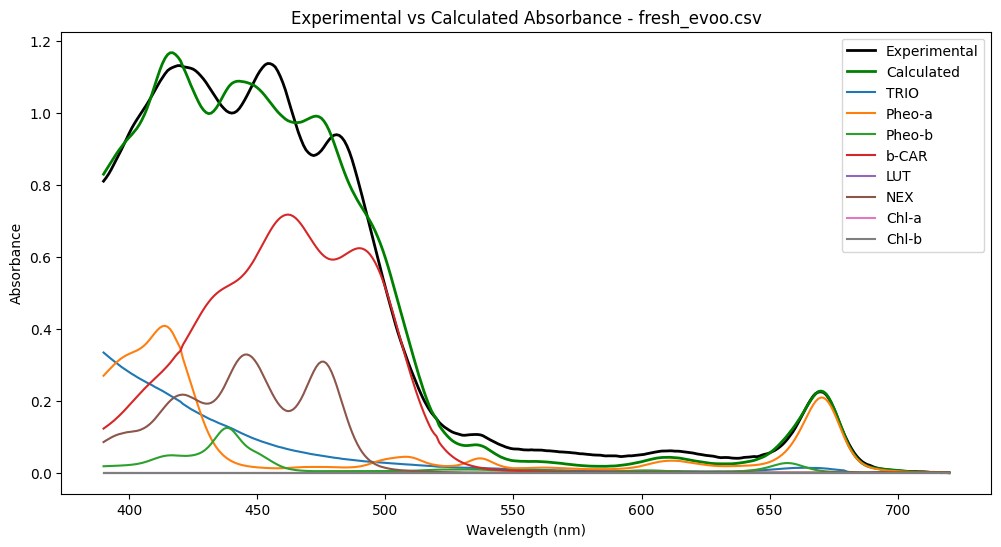

R-square = 0.991153
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = 328739.189 mg/kg
Pheo-a       = 395270.704 mg/kg
Pheo-b       = 122711.588 mg/kg
b-CAR        = 428073.148 mg/kg
LUT          =     0.000 mg/kg
NEX          = 219433.204 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     0.000 mg/kg
-------------------------------
PIGMENT TOTAL = 1494227.832 mg/kg


In [83]:
analyze_dataset(datasets[1], pigments_data)

## Analysis of Maize Seed Oil


Analyzing dataset: mais_seed_oil.csv
Epoch [500/5000], Loss: 0.0688
Epoch [1000/5000], Loss: 0.0303
Epoch [1500/5000], Loss: 0.0221
Epoch [2000/5000], Loss: 0.0177
Epoch [2500/5000], Loss: 0.0138
Epoch [3000/5000], Loss: 0.0104
Epoch [3500/5000], Loss: 0.0078
Epoch [4000/5000], Loss: 0.0060
Epoch [4500/5000], Loss: 0.0050
Epoch [5000/5000], Loss: 0.0045


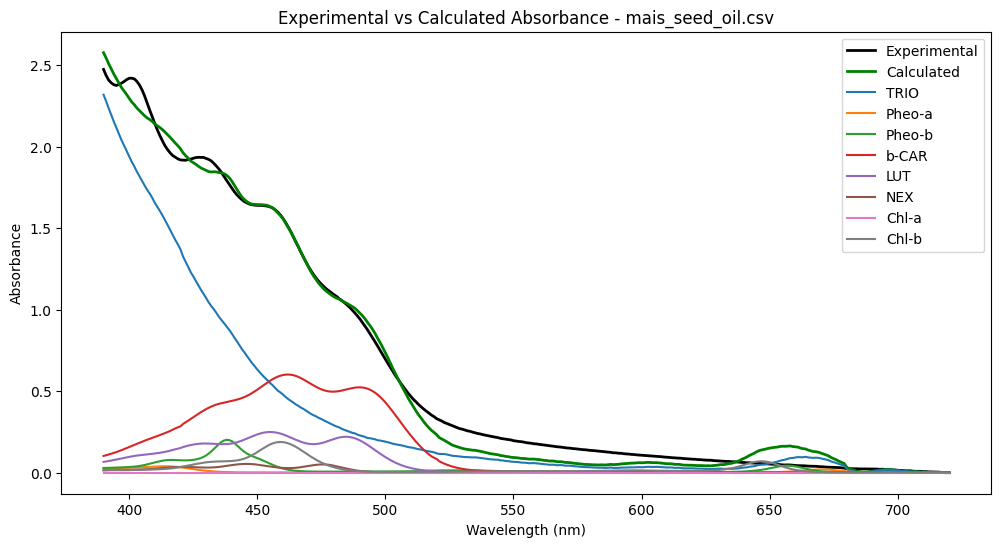

R-square = 0.992618
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = 2280743.426 mg/kg
Pheo-a       = 38244.263 mg/kg
Pheo-b       = 198508.863 mg/kg
b-CAR        = 359192.616 mg/kg
LUT          = 157841.297 mg/kg
NEX          = 36155.740 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        = 190094.628 mg/kg
-------------------------------
PIGMENT TOTAL = 3260780.832 mg/kg


In [84]:
analyze_dataset(datasets[2], pigments_data)

## Analysis of Monocultivar Frantoio


Analyzing dataset: monocultivar_frantoio.csv
Epoch [500/5000], Loss: 0.0739
Epoch [1000/5000], Loss: 0.0362
Epoch [1500/5000], Loss: 0.0152
Epoch [2000/5000], Loss: 0.0062
Epoch [2500/5000], Loss: 0.0032
Epoch [3000/5000], Loss: 0.0023
Epoch [3500/5000], Loss: 0.0020
Epoch [4000/5000], Loss: 0.0018
Epoch [4500/5000], Loss: 0.0017
Epoch [5000/5000], Loss: 0.0015


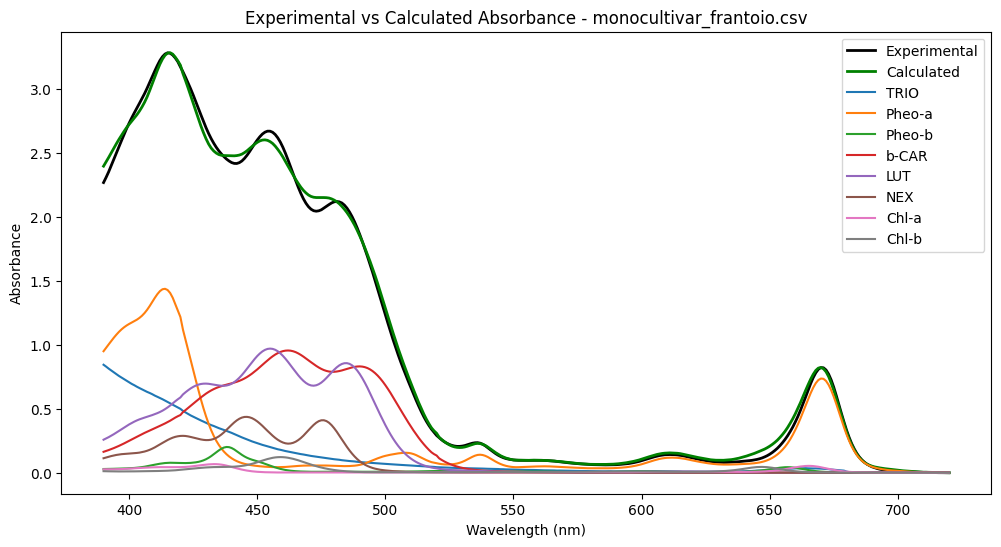

R-square = 0.998800
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = 829968.999 mg/kg
Pheo-a       = 1390909.295 mg/kg
Pheo-b       = 197774.503 mg/kg
b-CAR        = 569695.789 mg/kg
LUT          = 612922.640 mg/kg
NEX          = 291326.864 mg/kg
Chl-a        = 66605.974 mg/kg
Chl-b        = 123115.516 mg/kg
-------------------------------
PIGMENT TOTAL = 4082319.580 mg/kg


In [85]:
analyze_dataset(datasets[3], pigments_data)

## Analysis of Rapeseed Oil


Analyzing dataset: rapeseed_oil.csv
Epoch [500/5000], Loss: 0.1131
Epoch [1000/5000], Loss: 0.0478
Epoch [1500/5000], Loss: 0.0319
Epoch [2000/5000], Loss: 0.0234
Epoch [2500/5000], Loss: 0.0184
Epoch [3000/5000], Loss: 0.0155
Epoch [3500/5000], Loss: 0.0137
Epoch [4000/5000], Loss: 0.0124
Epoch [4500/5000], Loss: 0.0112
Epoch [5000/5000], Loss: 0.0100


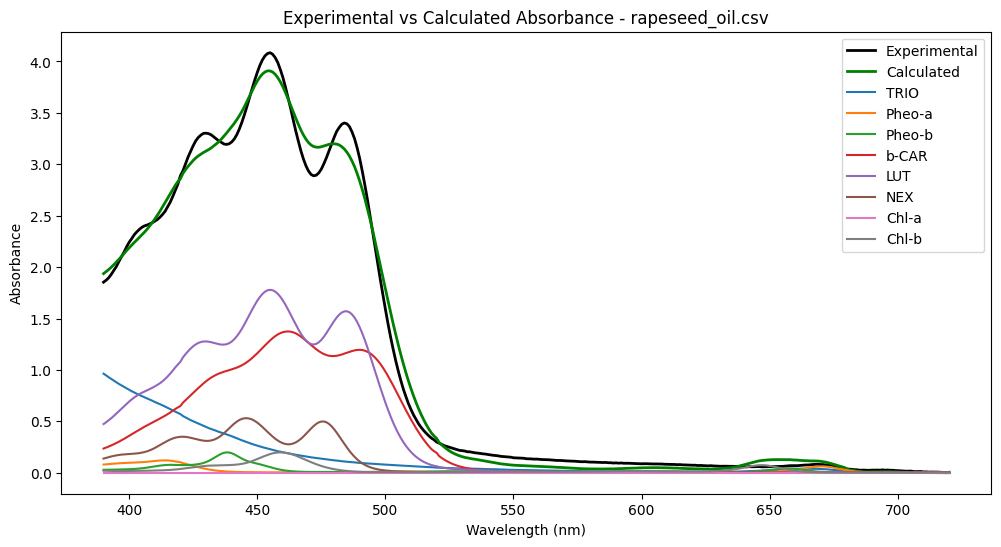

R-square = 0.994884
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = 947916.153 mg/kg
Pheo-a       = 116234.456 mg/kg
Pheo-b       = 194598.566 mg/kg
b-CAR        = 819859.743 mg/kg
LUT          = 1124384.783 mg/kg
NEX          = 354095.796 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        = 199390.827 mg/kg
-------------------------------
PIGMENT TOTAL = 3756480.324 mg/kg


In [86]:
analyze_dataset(datasets[4], pigments_data)